## DATA 608: Assignment 4 

Keith Folsom  
March 3, 2017
    
This week we will be looking at Enterococcus levels in the Hudson River, using data from the organization Riverkeeper ( http://www.riverkeeper.org/). 
 
Background: Enterococcus is a fecal indicating bacteria that lives in the intestines of humans and other warm-blooded animals. Enterococcus (“Entero”) counts are useful as a water quality indicator due to their abundance in human sewage, correlation with many human pathogens and low abundance in sewage free environments. The United States Environmental Protection Agency (EPA) reports Entero counts as colonies (or cells) per 100 ml of water. 
 
Riverkeeper has based its assessment of acceptable water quality on the 2012 Federal Recreational Water Quality Criteria from the US EPA. Unacceptable water is based on an illness rate of 32 per 1000 swimmers. 
 
The federal standard for unacceptable water quality is a single sample value of greater than 110 Enterococcus/100 mL, or five or more samples with a geometric mean (a weighted average) greater than 30 Enterococcus/100 mL. 

In [1]:
import pandas as pd
import re 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

%matplotlib inline

In [2]:
# load the 2013 Riverkeeper data from the csv file
# ------------------------------------------------------------------------------

river_data = pd.read_csv('~\Google Drive\Data Science\CUNY\DATA608 - Data Visualization\Assignment4/riverkeeper_data_2013.csv')

# inspect the results
river_data.head(10)


,Site,Date,EnteroCount,FourDayRainTotal,SampleCount
0,Hudson above Mohawk River,10/16/2011,1733,1.5,35
1,Hudson above Mohawk River,10/21/2013,4,0.2,35
2,Hudson above Mohawk River,9/21/2013,20,0.0,35
3,Hudson above Mohawk River,8/19/2013,6,0.0,35
4,Hudson above Mohawk River,7/21/2013,31,0.0,35
5,Hudson above Mohawk River,6/4/2013,238,1.2,35
6,Hudson above Mohawk River,10/15/2012,23,1.4,35
7,Hudson above Mohawk River,9/15/2012,11,0.1,35
8,Hudson above Mohawk River,8/18/2012,15,0.3,35
9,Hudson above Mohawk River,7/21/2012,6,0.2,35


In [3]:
river_data.describe()

,FourDayRainTotal,SampleCount
count,3397.000000,3397.000000
mean,0.568001,56.886370
std,1.000387,41.588476
min,0.000000,27.000000
25%,0.000000,37.000000
50%,0.200000,42.000000
75%,0.700000,50.000000
max,8.500000,187.000000


In [4]:
river_data.dtypes

Site                 object
Date                 object
EnteroCount          object
FourDayRainTotal    float64
SampleCount           int64
dtype: object

In [5]:
# NA values?
# -----------------------------

# check the entire data frame for null values
river_data.isnull().values.any()

False

In [6]:
# Data cleanup and typing
# -----------------------------

# convert the Date field to a date
river_data['Date'] = pd.to_datetime(river_data['Date'], format='%m/%d/%Y')

# EnteroCount contains some non-numeric characters (<, >).  Remove these and convert to an
river_data['EnteroCount'] = river_data['EnteroCount'].str.replace(r'\D+', '').astype('int')

river_data["FourDayRainTotal"] =  pd.to_numeric(river_data["FourDayRainTotal"])

# create a Year-Month column for aggregation later
river_data["Year-Month"] = river_data['Date'].apply(lambda x: x.strftime('%Y-%b'))  #B gives full month

river_data["Yr_Mth"]  = river_data.Date.dt.to_period("M")

river_data['Date'] = pd.to_datetime(river_data['Date'])

river_data["Month"]=pd.to_numeric(river_data["Date"].dt.month)
river_data["Year"]=pd.to_numeric(river_data["Date"].dt.year)

river_data.head(3)

,Site,Date,EnteroCount,FourDayRainTotal,SampleCount,Year-Month,Yr_Mth,Month,Year
0,Hudson above Mohawk River,2011-10-16,1733,1.5,35,2011-Oct,2011-10,10,2011
1,Hudson above Mohawk River,2013-10-21,4,0.2,35,2013-Oct,2013-10,10,2013
2,Hudson above Mohawk River,2013-09-21,20,0.0,35,2013-Sep,2013-09,9,2013


In [7]:
# create a data frame of aggegrates based on each site
# ------------------------------------------------------------

# Define the aggregation calculations
agg_river_data =  river_data.groupby(['Site']).agg({
                                                     "EnteroCount": {
                                                                     "MinEnteroCount":    "min",
                                                                     "AvgEnteroCount":    "mean",
                                                                     "MedianEnteroCount": "median",
                                                                     "MaxEnteroCount":    "max"},
                                                      "Date" : { 
                                                                     "LastMeasured": "max"},
                                                      "FourDayRainTotal" : {
                                                                      "AvgRain"  : "mean",
                                                                      "TotalRain": "sum"}
    
                                                   }) 
# The aggregation left us with a multi-index
# Remove the top level of this index
agg_river_data.columns = agg_river_data.columns.droplevel(level=0) 

agg_river_data.head(10)

,LastMeasured,TotalRain,AvgRain,AvgEnteroCount,MaxEnteroCount,MinEnteroCount,MedianEnteroCount
Site,,,,,,,
125th St. Pier,2013-10-16,50.9,0.771212,179.696970,1500,8,43.5
79th St. mid-channel,2013-10-16,42.2,0.861224,47.204082,1032,1,10.0
Albany Rowing Dock,2013-10-21,22.7,0.630556,280.944444,2420,3,48.0
Annesville Creek,2013-10-17,18.4,0.484211,83.421053,958,5,10.0
Athens,2013-10-21,20.9,0.597143,201.314286,2420,5,30.0
Beacon Harbor,2013-10-18,14.0,0.368421,52.657895,816,1,19.0
Bethlehem Launch Ramp,2013-10-21,20.5,0.569444,231.694444,2420,1,19.0
"Castle Point, NJ",2013-10-16,25.9,0.664103,37.076923,231,10,20.0
Castleton,2013-10-21,20.6,0.588571,186.000000,1733,1,22.0


## Question 1

Create lists & graphs of the best and worst places to swim in the dataset. 

In [8]:
# Top 10 Worst #
# -----------------------------

top10_worst = agg_river_data['MedianEnteroCount'].nlargest(10)
top10_worst = top10_worst.reset_index()

__Let's look at the top 10 sites with the highest median Entero counts:__

In [9]:

top10_worst

,Site,MedianEnteroCount
0,Upper Sparkill Creek,411.0
1,Mohawk River at Waterford,130.0
2,Newburgh Launch Ramp,120.0
3,Piermont Pier,99.0
4,Newtown Creek- Metropolitan Ave. Bridge,98.0
5,Gowanus Canal,96.0
6,Saw Mill River,86.0
7,Dunn Memorial Bridge- Albany,80.0
8,Hudson River above Troy Lock,67.0
9,Kingston STP Outfall,67.0


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

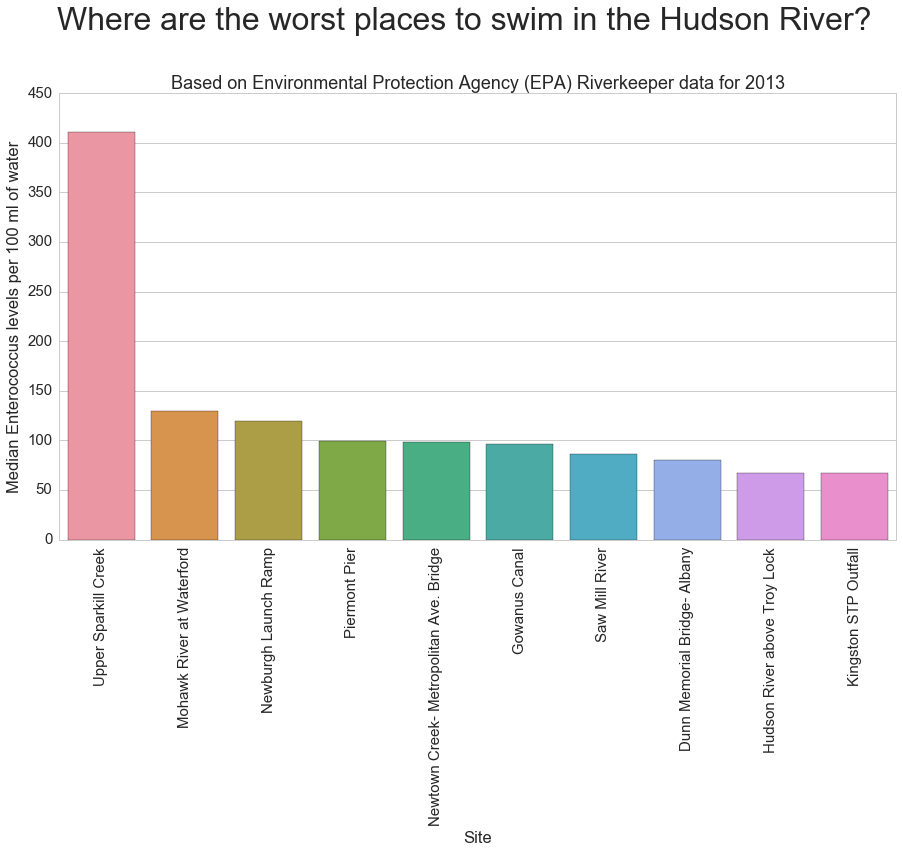

In [10]:
# Generate plot of percentage of the top 10 worst sites
# ---------------------------------------------------------------------

plt.figure(figsize=(15,8))
sns.set_style("whitegrid")    # Set style for seaborn output
sns.set_context("notebook", font_scale=1.5)
sns.barplot(x="Site", y="MedianEnteroCount", data=top10_worst.sort_values('MedianEnteroCount', ascending=False))
plt.xlabel("Site")
plt.ylabel("Median Enterococcus levels per 100 ml of water")
plt.suptitle("Where are the worst places to swim in the Hudson River?", y=1.05, fontsize=32)
plt.title("Based on Environmental Protection Agency (EPA) Riverkeeper data for 2013", fontsize=18)
plt.xticks(rotation=90)

__Let's look at the top 10 sites with the lowest median Entero counts:__

In [11]:
### Top 10 Best #
# ---------------------------------------------------------------------
# For the top 10 best sites, only consider sites that have been last measured in 2013.  Any sites that have not
# been measured in 2013 will be excluded from consideration

top10_best = agg_river_data[(agg_river_data["LastMeasured"] >= '2013-01-01')].MedianEnteroCount.nsmallest(10)
top10_best = top10_best.reset_index()

In [12]:
top10_best

,Site,MedianEnteroCount
0,Norrie Point mid-channel,2.5
1,Port Ewen Drinking Water Intake,4.0
2,Tivoli Landing,4.0
3,Poughkeepsie Drinking Water Intake,4.5
4,West Point STP Outfall,7.0
5,Kingston Point Beach,8.0
6,Ulster Landing Beach,8.5
7,Marlboro Landing,9.0
8,Wappingers Creek,9.0
9,79th St. mid-channel,10.0


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

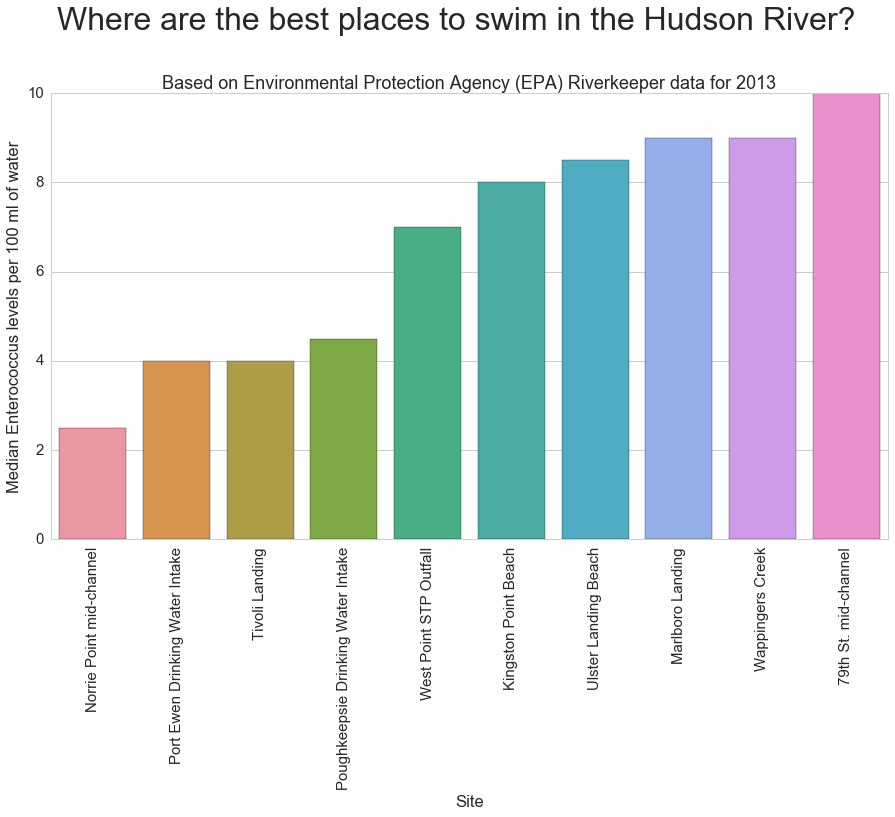

In [13]:
# Generate plot of percentage of the top 10 best sites
# ---------------------------------------------------------------------
plt.figure(figsize=(15,8))
sns.set_style("whitegrid")    # Set style for seaborn output
sns.set_context("notebook", font_scale=1.5)
sns.barplot(x="Site", y="MedianEnteroCount", data=top10_best.sort_values('MedianEnteroCount', ascending=True))
plt.xlabel("Site")
plt.ylabel("Median Enterococcus levels per 100 ml of water")
plt.suptitle("Where are the best places to swim in the Hudson River?", y=1.05, fontsize=32)
plt.title("Based on Environmental Protection Agency (EPA) Riverkeeper data for 2013", fontsize=18)
plt.xticks(rotation=90)

## Question 2 

The testing of water quality can be sporadic. Which sites have been tested most regularly? Which ones have long gaps between tests? Pick out 5-10 sites and visually compare how regularly their water quality is tested.


In [14]:
# calculate the number of days between each site's last reading
# this will be used to asses how frequently sites are tested

rd_test_dates = river_data[["Site", "Date"]].sort_values(['Site', 'Date'], ascending=True)

# create a new field to store the previous testing date for the site

rd_test_dates["Days_Between"] = rd_test_dates.groupby('Site')['Date'].diff() / np.timedelta64(1, 'D')
rd_test_dates['Days_Between'] = rd_test_dates['Days_Between'].fillna(0)

rd_test_dates.head(10)

,Site,Date,Days_Between
2923,125th St. Pier,2006-10-02,0.0
2919,125th St. Pier,2006-10-03,1.0
2917,125th St. Pier,2006-10-06,3.0
2916,125th St. Pier,2006-10-11,5.0
2915,125th St. Pier,2006-10-12,1.0
2914,125th St. Pier,2006-10-31,19.0
2913,125th St. Pier,2007-05-29,210.0
2912,125th St. Pier,2007-05-30,1.0
2911,125th St. Pier,2007-05-31,1.0
2909,125th St. Pier,2007-06-01,1.0


In [15]:
site_stats = rd_test_dates.groupby(['Site']).agg({
                                               "Days_Between": {"NumberofReadings":  "count",
                                                                "MinDaysBetween":    "min",
                                                                "AvgDaysBetween":    "mean",
                                                                "MedianDaysBetween": "median",
                                                                "MaxDaysBetween":    "max"}
                                             }) 

site_stats.columns = site_stats.columns.droplevel(level=0) 

site_stats.head(5)


,AvgDaysBetween,NumberofReadings,MedianDaysBetween,MinDaysBetween,MaxDaysBetween
Site,,,,,
125th St. Pier,38.954545,66,25.0,0.0,291.0
79th St. mid-channel,52.591837,49,28.0,0.0,256.0
Albany Rowing Dock,54.944444,36,29.5,0.0,232.0
Annesville Creek,52.000000,38,28.0,0.0,231.0
Athens,55.742857,35,30.0,0.0,232.0


In [16]:
# Most frequently tested sites #

freq5_best = site_stats.AvgDaysBetween.nsmallest(5)
freq5_best = freq5_best.reset_index()
freq5_best

,Site,AvgDaysBetween
0,Upper Sparkill Creek,13.636364
1,Piermont Pier,13.673797
2,Nyack Launch Ramp,31.950820
3,125th St. Pier,38.954545
4,Rondout- Eddyville Anchorage,43.933333


In [17]:
# Sites with the biggest gap between testing #
freq5_worst = site_stats.AvgDaysBetween.nlargest(5)
freq5_worst = freq5_worst.reset_index()
freq5_worst

,Site,AvgDaysBetween
0,Tarrytown Marina,70.296296
1,Gowanus Canal,64.135135
2,Stony Point mid-channel,58.750000
3,Hudson above Mohawk River,56.514286
4,Mohawk River at Waterford,56.514286


In [18]:
# combine the most and least frequently tested sites for later use
combined_result = pd.concat([freq5_worst, freq5_best])

combined_result

,Site,AvgDaysBetween
0,Tarrytown Marina,70.296296
1,Gowanus Canal,64.135135
2,Stony Point mid-channel,58.750000
3,Hudson above Mohawk River,56.514286
4,Mohawk River at Waterford,56.514286
0,Upper Sparkill Creek,13.636364
1,Piermont Pier,13.673797
2,Nyack Launch Ramp,31.950820
3,125th St. Pier,38.954545
4,Rondout- Eddyville Anchorage,43.933333


In [19]:
# create a site-level aggregate data frame where the total number of measurements per month are calculated

#grouped_river_data = river_data.groupby(["Site", "Year-Month", "Year", "Month"]).agg({'Site': {"TotalSamples": "size"}})
#Yr_Mth

grouped_river_data = river_data.groupby(["Site", "Yr_Mth"]).agg({'Site': {"TotalSamples": "size"}})
grouped_river_data.columns = grouped_river_data.columns.droplevel(level=0) 
grouped_river_data = grouped_river_data.reset_index()

# apply a sort order 
grouped_river_data = grouped_river_data.sort_values(["Site", "Yr_Mth"], ascending=[True, True])

grouped_river_data.head(10)

,Site,Yr_Mth,TotalSamples
0,125th St. Pier,2006-10,6
1,125th St. Pier,2007-05,3
2,125th St. Pier,2007-06,14
3,125th St. Pier,2007-07,3
4,125th St. Pier,2007-08,2
5,125th St. Pier,2008-05,1
6,125th St. Pier,2008-07,2
7,125th St. Pier,2008-08,1
8,125th St. Pier,2008-09,1
9,125th St. Pier,2008-10,1


In [20]:
# Extract the site data for the 10 sites identified as the most and least frequently tested

chart_data = grouped_river_data[grouped_river_data.Site.isin(combined_result.Site)]
chart_data.head(10)

# create a range of dates starting from 2006 to 2013 by month
# these will be used to fill the missing months in each site's montly readings
range = pd.date_range('1/1/2006', periods=96, freq='M').to_period("M")
            
# convert the range to a dataframe   
range_df = pd.DataFrame(range.to_datetime()) 
range_df[0] = range_df[0].dt.to_period("M")

# set the column name
range_df.columns = ['Yr_Mth']

site_range_df = pd.DataFrame()
# iterate through each of the sites creating the range of dates for each site
for index, row in combined_result.iterrows():
     dftemp = range_df
     dftemp ["Site"] =  row['Site']
     site_range_df =  site_range_df.append(dftemp, ignore_index=True)
      

site_range_df.head(10)

    

,Yr_Mth,Site
0,2006-01,Tarrytown Marina
1,2006-02,Tarrytown Marina
2,2006-03,Tarrytown Marina
3,2006-04,Tarrytown Marina
4,2006-05,Tarrytown Marina
5,2006-06,Tarrytown Marina
6,2006-07,Tarrytown Marina
7,2006-08,Tarrytown Marina
8,2006-09,Tarrytown Marina
9,2006-10,Tarrytown Marina


In [21]:
# create the date filled data to be filled
# there is probably a better way to do this.  Resampled seemed to do something similar

# merge the actual site data with the site's data range dataframe
chart_filled = pd.merge(chart_data, site_range_df, on=['Yr_Mth', 'Site'], how='outer', indicator=True)

#chart_filled.head(10)

In [22]:
# format the Yr-Mth field into a date to it displays correctly in the graph
# not sure how else to format date correctly; Yr_Mth shows as a number without applying this code
chart_filled['Yr_Mth'] = chart_filled['Yr_Mth'].apply(lambda x : datetime.date(x.year, x.month, 1))


In [23]:
# create the pivot to plot the data in a heatmap

pivot = chart_filled.pivot(index = 'Site', columns = 'Yr_Mth',  values = 'TotalSamples')
pivot.fillna(0, inplace=True) 


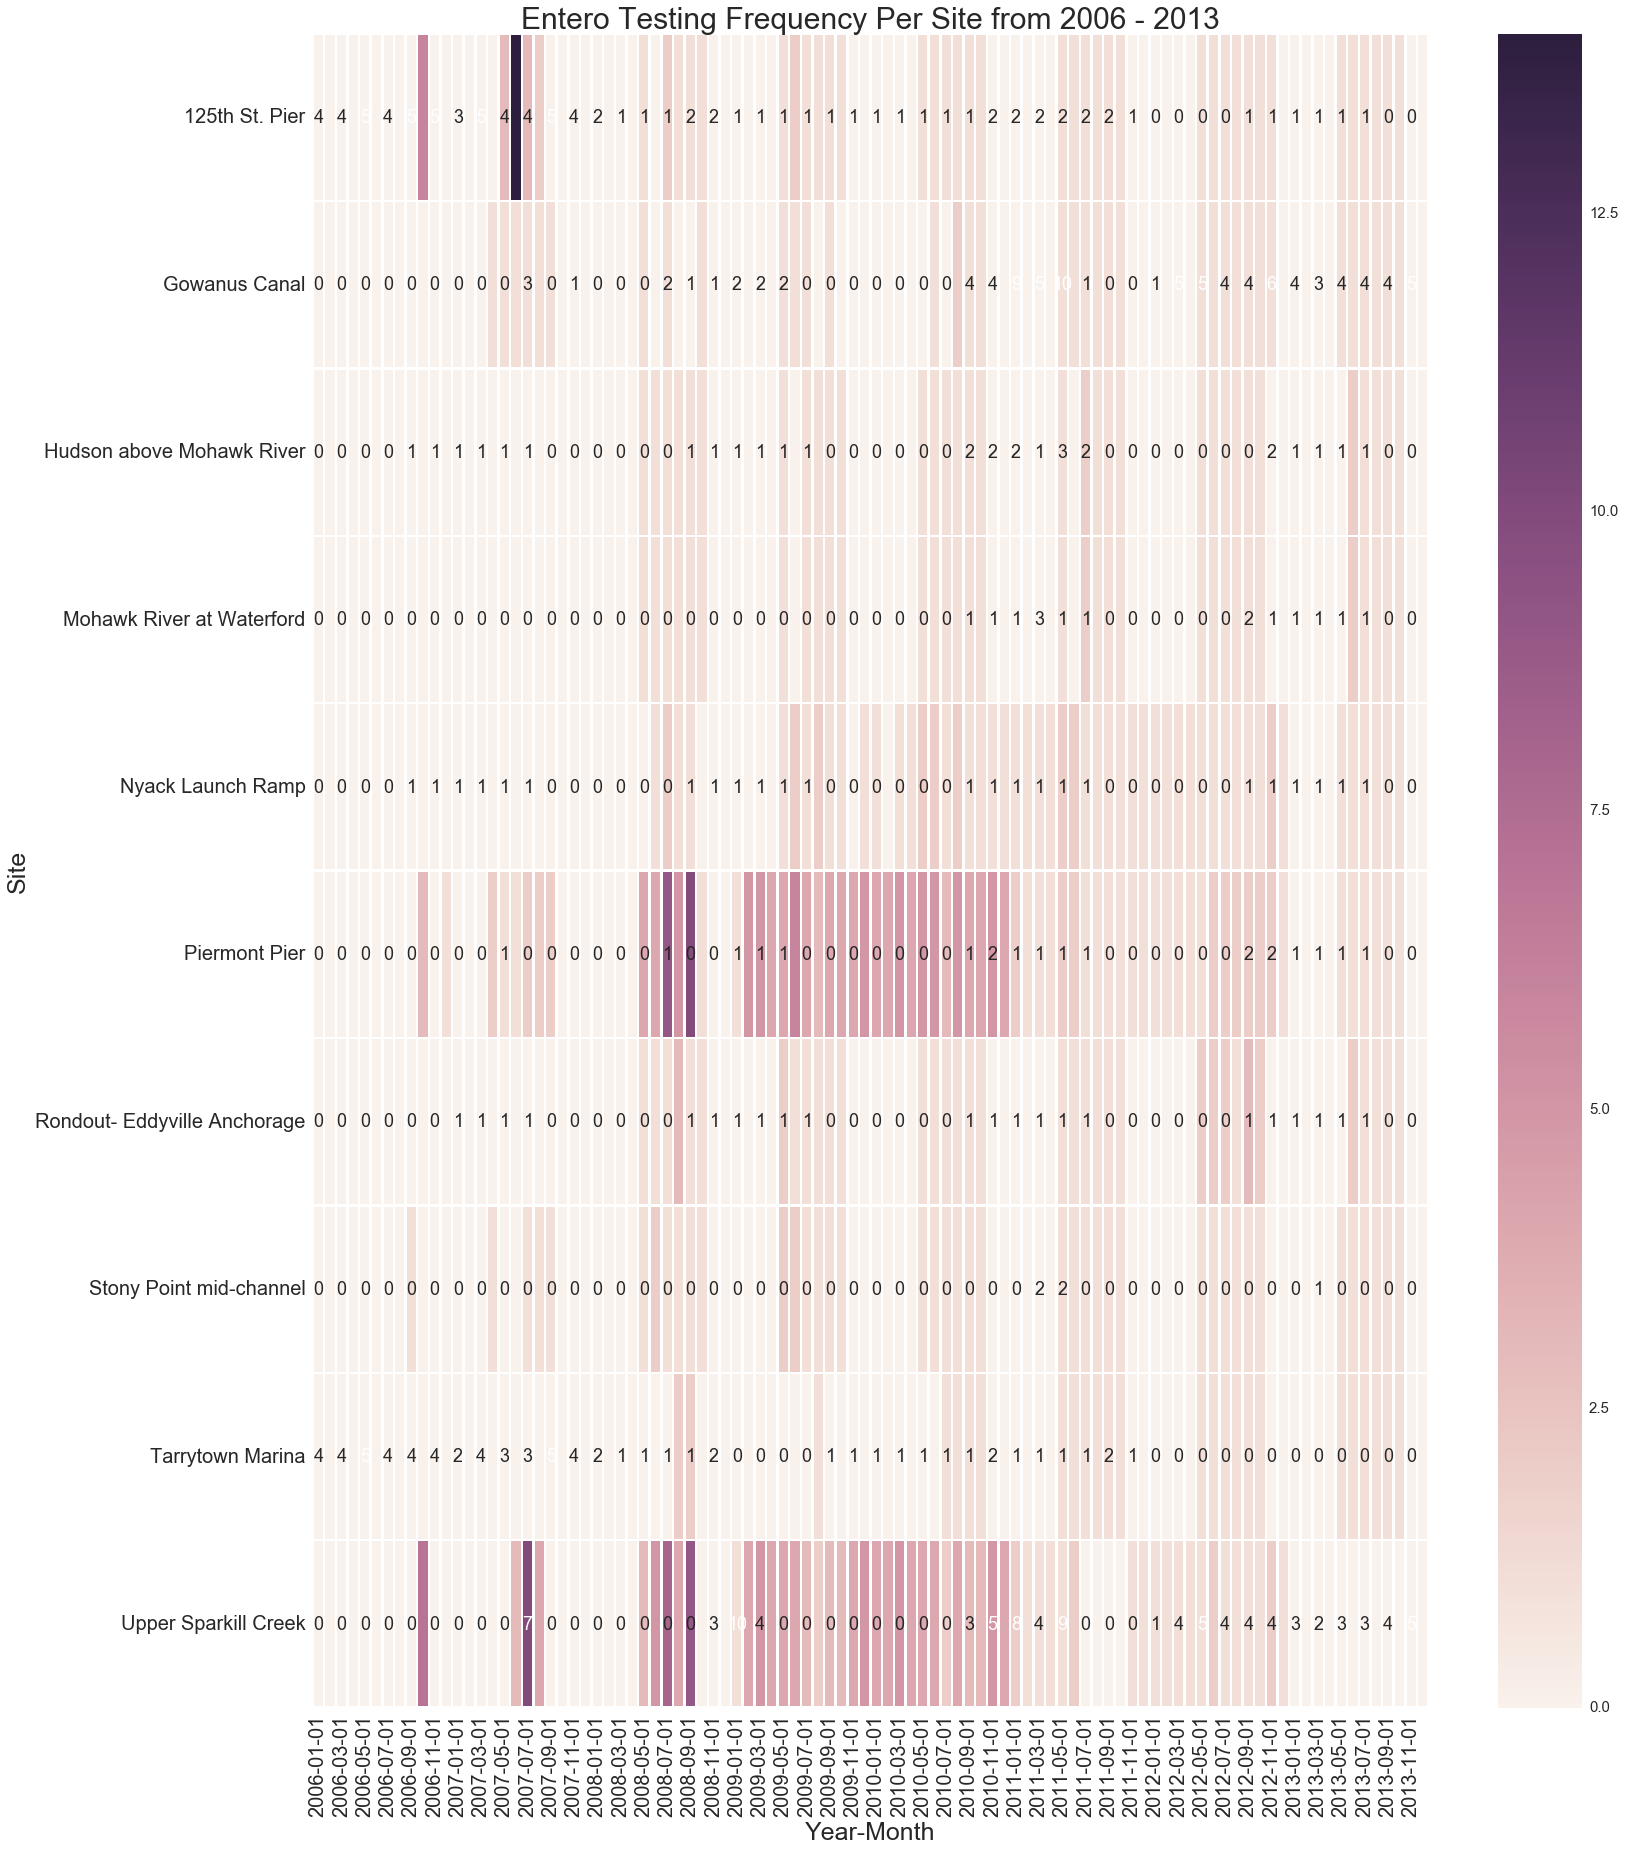

In [24]:
# Plot the 10 sites in a heatmap to see the how often they are test by month from 2006 - 2013

plt.figure(figsize=(25, 30))
sns.set_style("whitegrid") 
sns.set(font_scale=1.5)

p = sns.heatmap(pivot, annot=True, linewidths=1.5, xticklabels=2) #, fmt="g"

sns.plt.title("Entero Testing Frequency Per Site from 2006 - 2013", fontsize=30)
p.set_xlabel("Year-Month", fontsize=25)
p.set_ylabel("Site", fontsize=25)
p.tick_params(labelsize=20)

## Question 3  

Is there a relationship between the amount of rain and water quality?  Show this relationship graphically. If you can, estimate the effect of rain on quality at different sites and create a visualization to compare them.

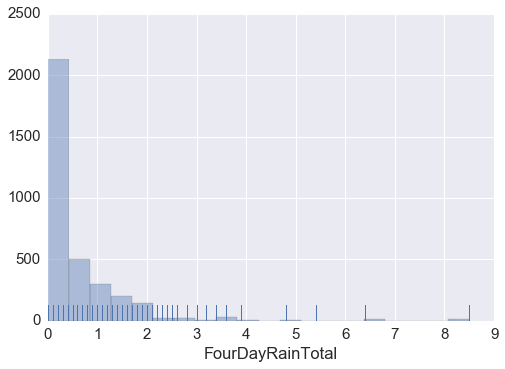

In [25]:
# let's look at the distribution of rainfall, given by FourDayRainTotal

sns.distplot(river_data["FourDayRainTotal"], bins=20, kde=False, rug=True);


In [26]:
river_data['FourDayRainTotal'].describe()


count    3397.000000
mean        0.568001
std         1.000387
min         0.000000
25%         0.000000
50%         0.200000
75%         0.700000
max         8.500000
Name: FourDayRainTotal, dtype: float64

In [27]:
# classify each site's rainfall into high, medium, or low

# RainLevel = low is when the AvgRain quantile is below 25%
# RainLevel = Medium is when the AvgRain quantile is between 25% and 75% 
# RainLevel = High is when the AvgRain quantile is above 75%
agg_river_data["RainLevel"] = "Medium"

# low
agg_river_data.loc[agg_river_data['AvgRain'] < agg_river_data.AvgRain.quantile(.25), 'RainLevel'] = 'Low'

# High
agg_river_data.loc[agg_river_data['AvgRain'] > agg_river_data.AvgRain.quantile(.75), 'RainLevel'] = 'High'

agg_river_data.head(5)


,LastMeasured,TotalRain,AvgRain,AvgEnteroCount,MaxEnteroCount,MinEnteroCount,MedianEnteroCount,RainLevel
Site,,,,,,,,
125th St. Pier,2013-10-16,50.9,0.771212,179.696970,1500,8,43.5,High
79th St. mid-channel,2013-10-16,42.2,0.861224,47.204082,1032,1,10.0,High
Albany Rowing Dock,2013-10-21,22.7,0.630556,280.944444,2420,3,48.0,Medium
Annesville Creek,2013-10-17,18.4,0.484211,83.421053,958,5,10.0,Medium
Athens,2013-10-21,20.9,0.597143,201.314286,2420,5,30.0,Medium


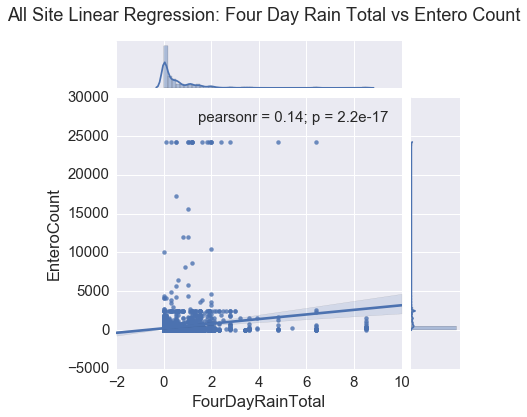

In [28]:
# Look at all sites using JointPlot 

ax1 = sns.jointplot("FourDayRainTotal", "EnteroCount", river_data, kind="reg")
ax1.fig.subplots_adjust(top=0.9)
sns.plt.suptitle("All Site Linear Regression: Four Day Rain Total vs Entero Count")
plt.show()

We see a weak relationship between FourDayRainTotal and Entero Count.  Pearson's R value at 0.14 is low.

Let's look at sites by their classification of rainfall level - High, Medium, or Low.

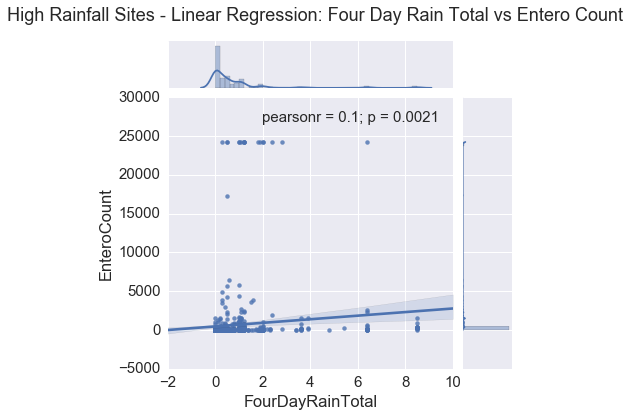

In [29]:
high_rainfall_sites =  river_data[river_data.Site.isin(agg_river_data[agg_river_data.RainLevel=="High"].index)]

ax1 = sns.jointplot("FourDayRainTotal", "EnteroCount", high_rainfall_sites, kind="reg")
ax1.fig.subplots_adjust(top=0.9)
sns.plt.suptitle("High Rainfall Sites - Linear Regression: Four Day Rain Total vs Entero Count")
plt.show()

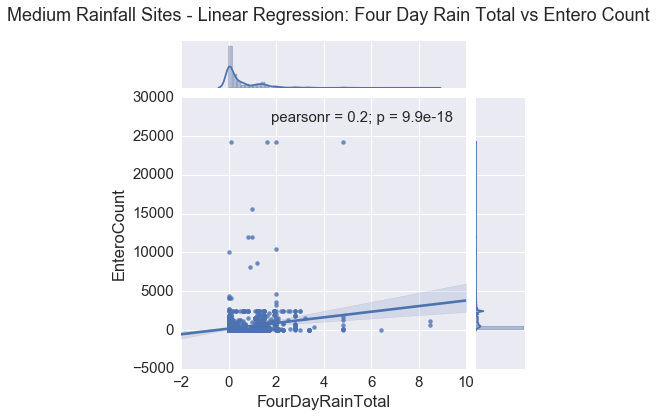

In [30]:
med_rainfall_sites =  river_data[river_data.Site.isin(agg_river_data[agg_river_data.RainLevel=="Medium"].index)]

ax1 = sns.jointplot("FourDayRainTotal", "EnteroCount", med_rainfall_sites, kind="reg")
ax1.fig.subplots_adjust(top=0.9)
sns.plt.suptitle("Medium Rainfall Sites - Linear Regression: Four Day Rain Total vs Entero Count")
plt.show()

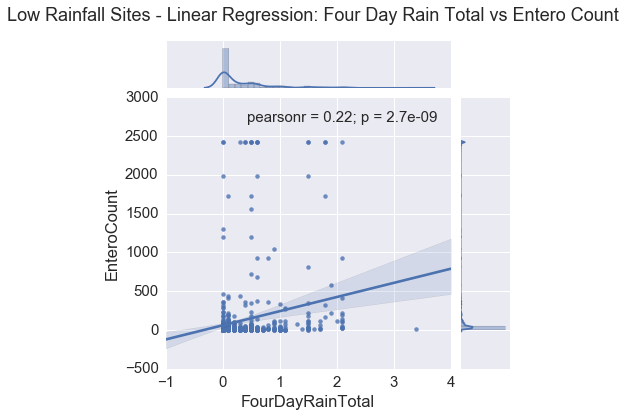

In [31]:
low_rainfall_sites =  river_data[river_data.Site.isin(agg_river_data[agg_river_data.RainLevel=="Low"].index)]

ax1 = sns.jointplot("FourDayRainTotal", "EnteroCount", low_rainfall_sites, kind="reg")
ax1.fig.subplots_adjust(top=0.9)
sns.plt.suptitle("Low Rainfall Sites - Linear Regression: Four Day Rain Total vs Entero Count")
plt.show()

The preceding three graphs for high, medium, and low rainfaill sites show that there appears to be a weak relationship between sites with less rainfall and higher Entero counts. 

Plot each site individually with a linear regression showing the relationship between rainfall and Entero count.

### Low Rainfall Sites

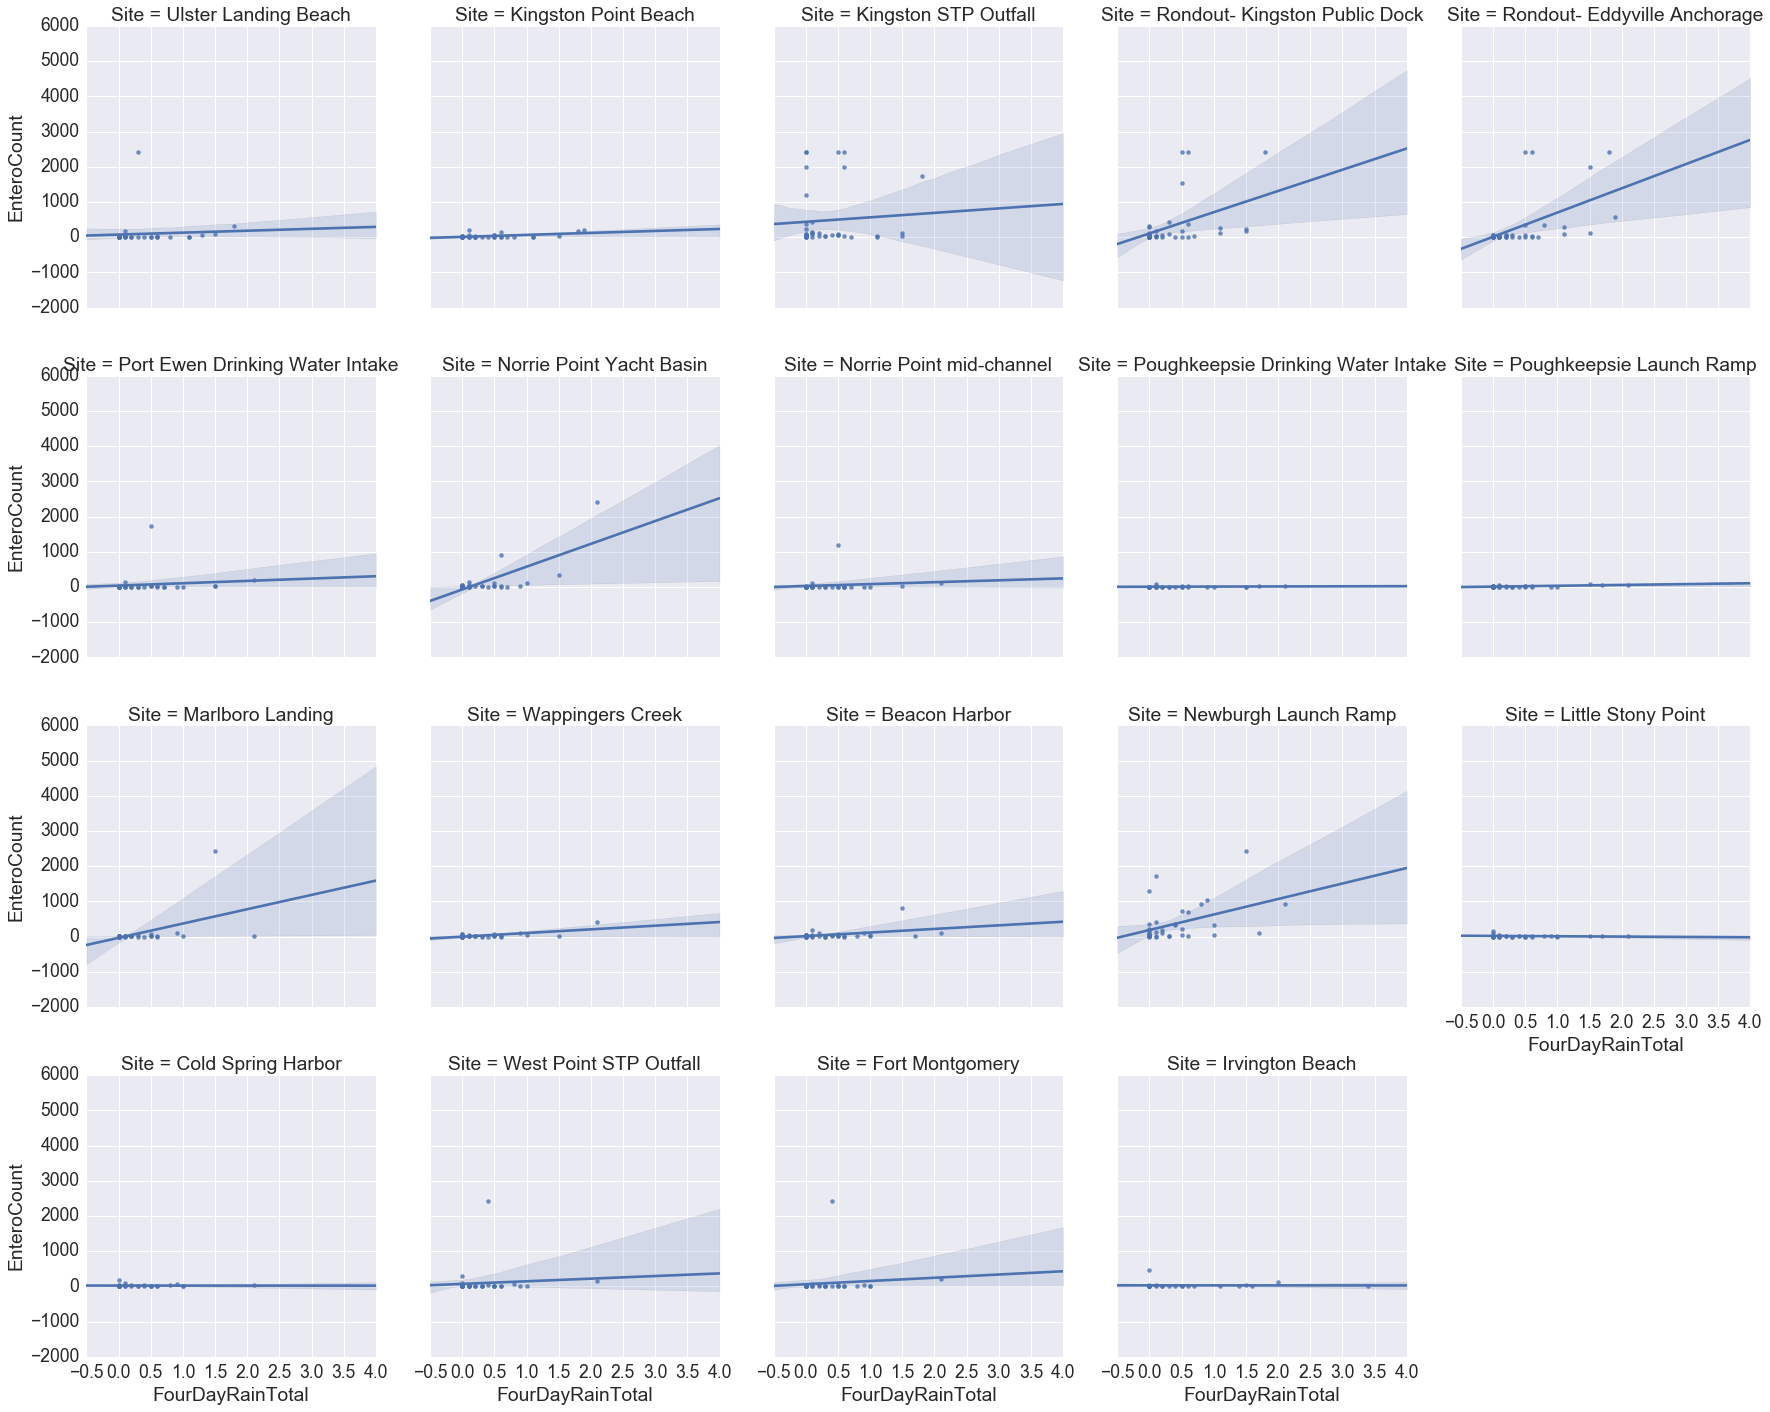

In [32]:
sns.set(font_scale=1.75)
sns.lmplot(x="FourDayRainTotal", y="EnteroCount", col="Site", data=low_rainfall_sites, col_wrap = 5);


### Medium Rainfall Sites

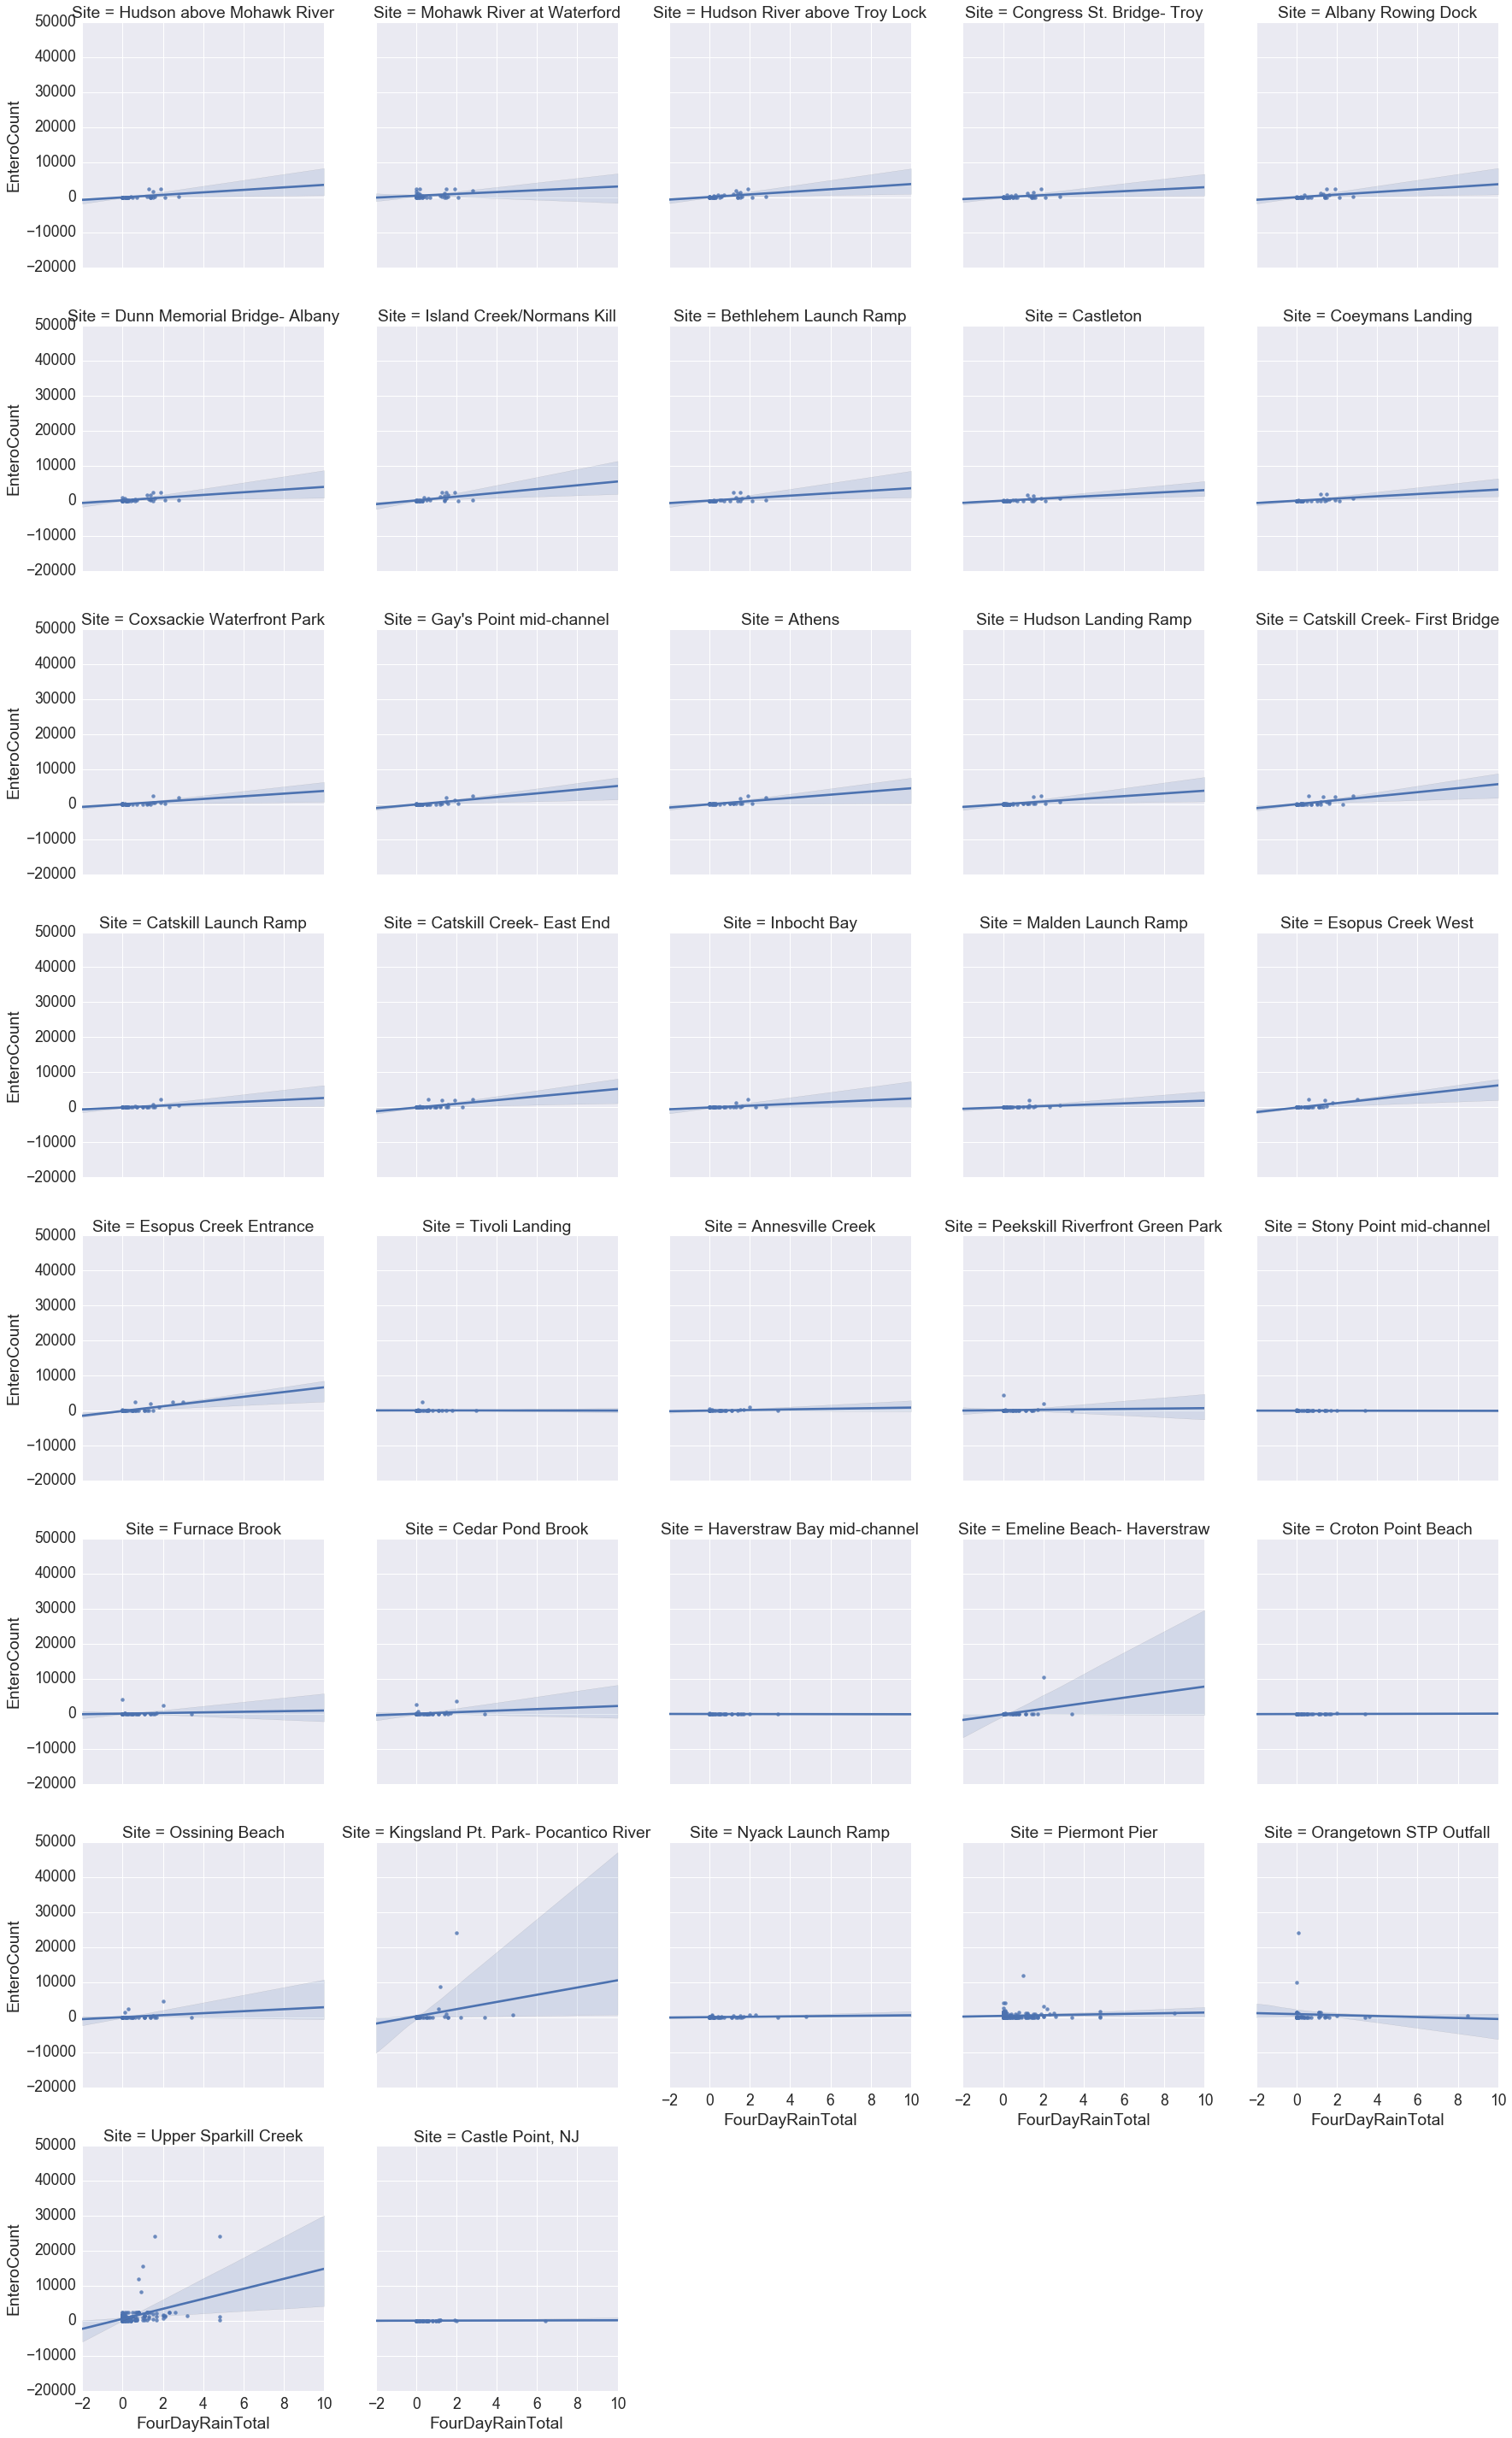

In [33]:
sns.set(font_scale=1.75)
sns.lmplot(x="FourDayRainTotal", y="EnteroCount", col="Site", data=med_rainfall_sites, col_wrap = 5);


###  High Rainfall Sites

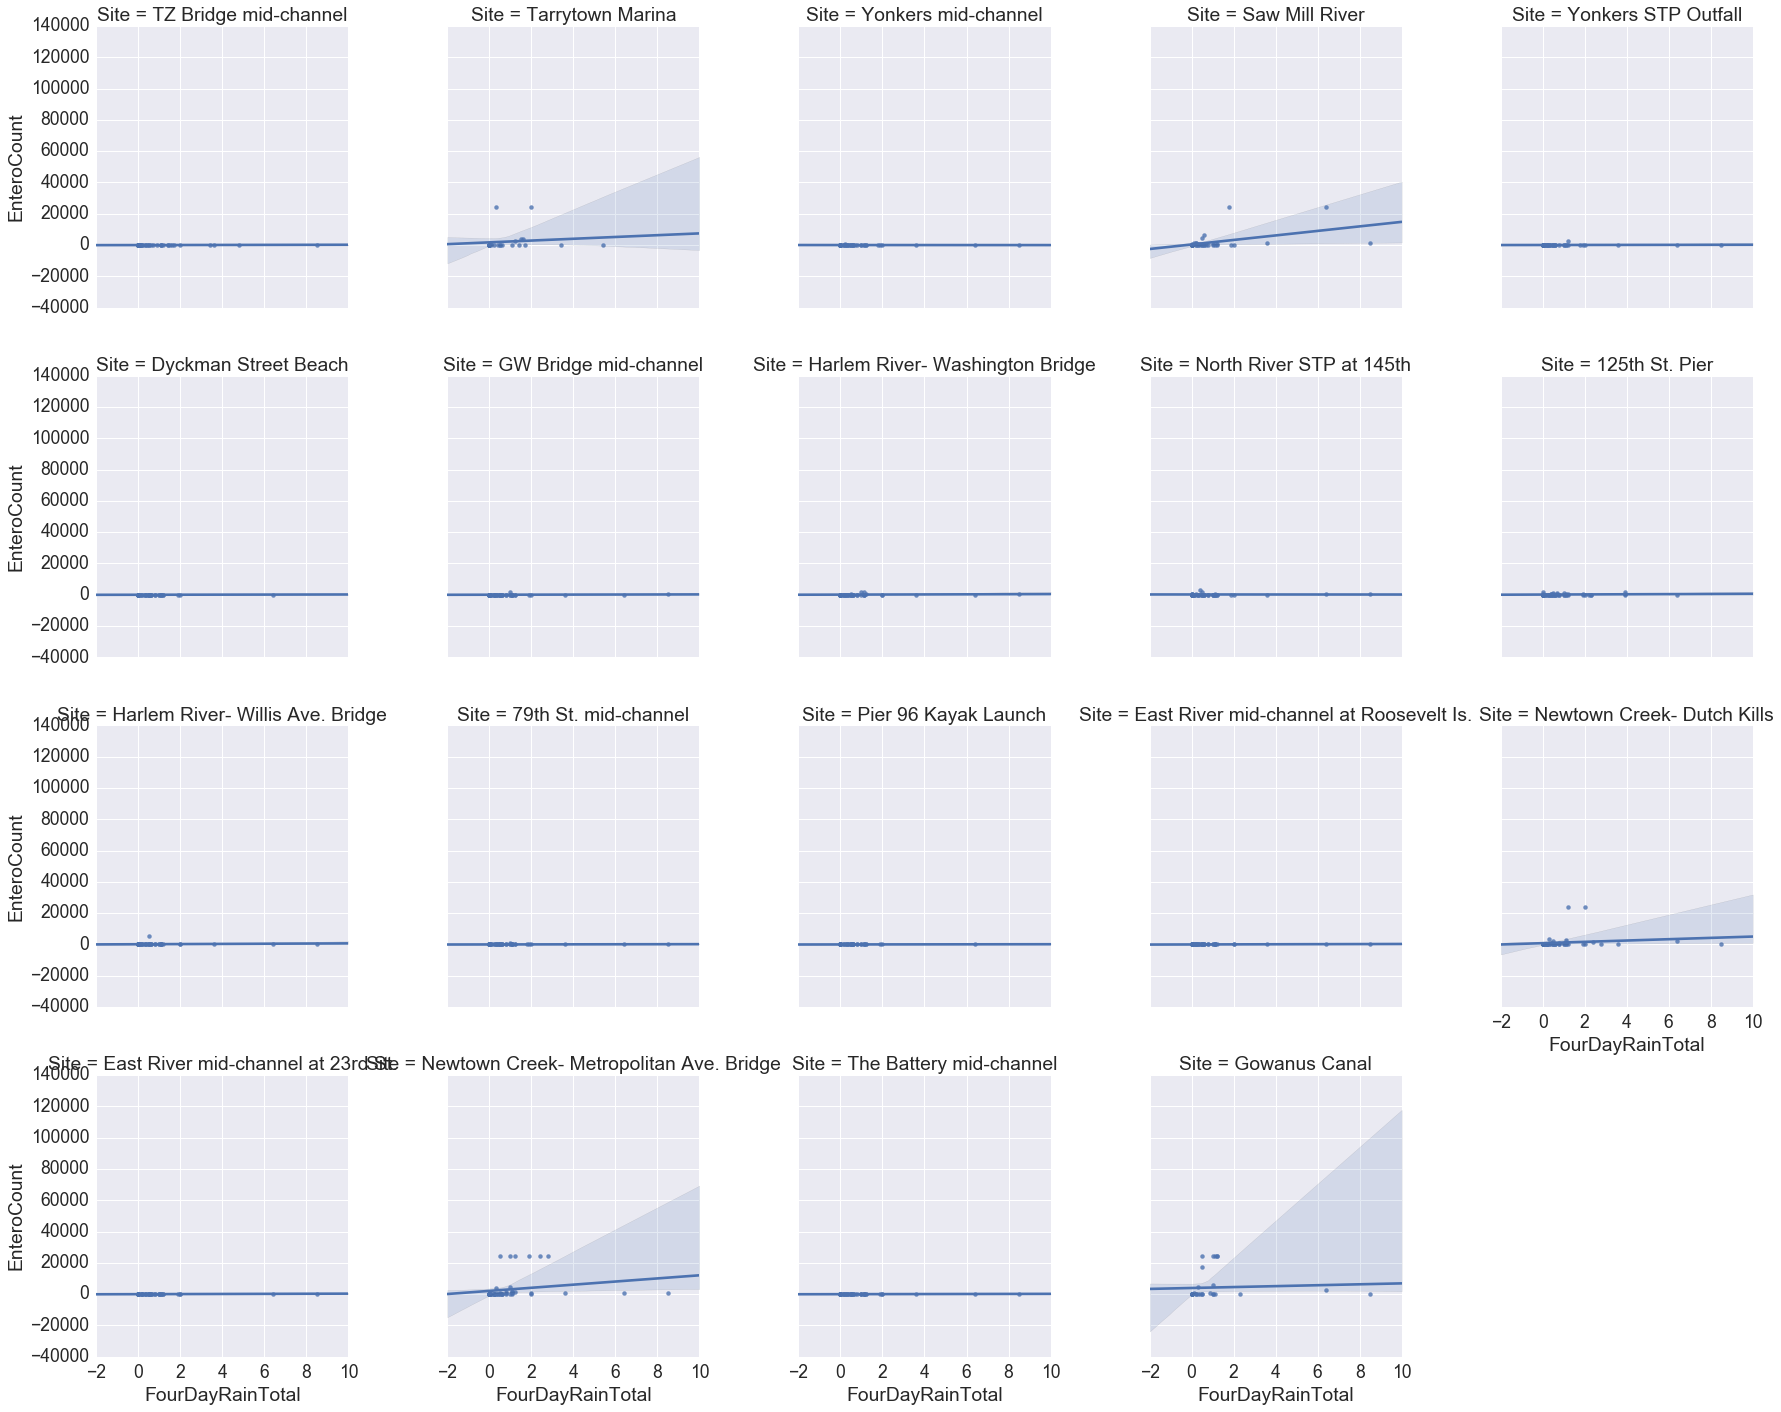

In [35]:
sns.set(font_scale=1.75)
sns.lmplot(x="FourDayRainTotal", y="EnteroCount", col="Site", data=high_rainfall_sites, col_wrap = 5);